In [1]:
import torch

In [10]:
device = torch.device("cuda:0")

In [28]:
tt = torch.rand(10,1, device=device)

In [30]:
torch.matmul(tt.T,tt)

tensor([[3.2152]], device='cuda:0')

In [1]:
from ipywidgets import widgets

In [5]:
int_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=12,
    step=1,
    description='Month:',
    continuous_update=True
)


gvalue = None
def widget_callback(change):
    global gvalue
    gvalue = change

    
int_slider.observe(widget_callback, names="value")

play_button = widgets.Play(
    value=1,
    min=1,
    max=12,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (int_slider, 'value'))

widgets.VBox([
    play_button,
    int_slider,
])

In [13]:
gvalue

{'name': 'value',
 'old': 7,
 'new': 8,
 'owner': IntSlider(value=8, description='Month:', max=12, min=1),
 'type': 'change'}

In [20]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.plots import im

In [35]:
data_sub_path = "T24H-X850M-Y880M_2012-01-01_2019-01-01"
file_location = f"./data/processed/{data_sub_path}/generated_data.npz"
if os.path.exists(file_location):
    with np.load(file_location) as zip_file:  # context helper ensures zip_file is closed
        print(list(zip_file.keys()))
        crime_grids = zip_file["crime_grids"]
        x_range = zip_file["x_range"]
        y_range = zip_file["y_range"]

['crime_feature_indices', 'crime_types_grids', 'crime_grids', 'tract_count_grids', 'demog_grid', 'street_grid', 'time_vectors', 'weather_vectors', 'x_range', 'y_range']


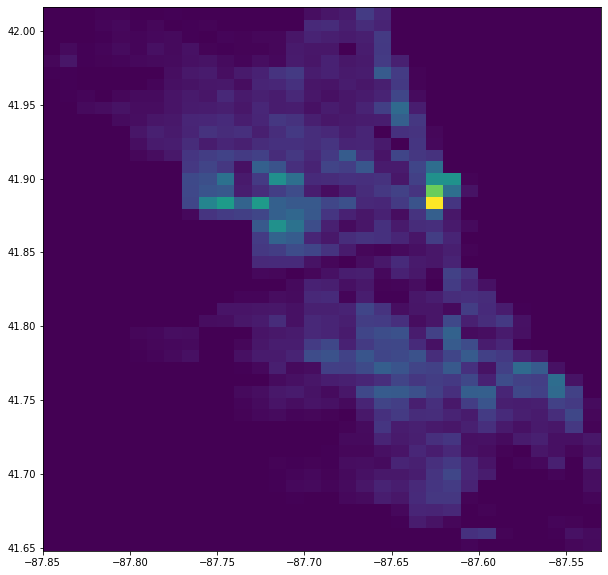

In [33]:
mean = crime_grids.mean(axis=(0,1))

grid = np.flipud(mean)


plt.figure(figsize=(10,10))
xx, yy = np.meshgrid(x_range, y_range)
plt.pcolormesh(xx, yy, grid)
plt.show()

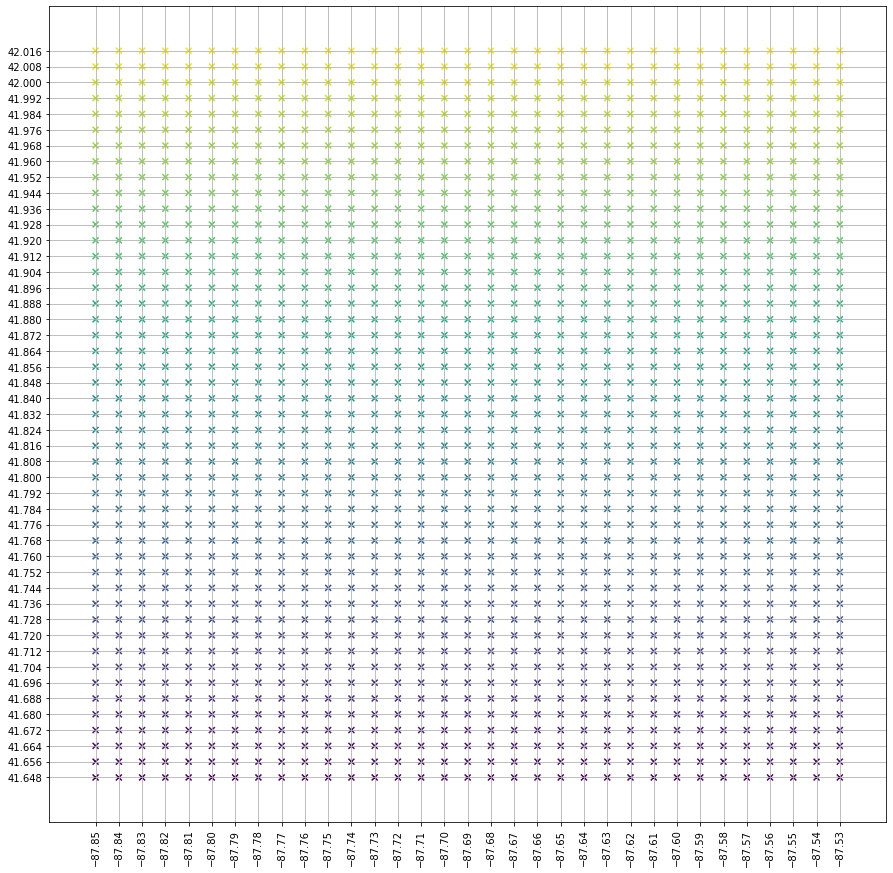

In [82]:
x_min, x_max = x_range[0], x_range[-1]
y_min, y_max = y_range[0], y_range[-1]

y_ticks = np.linspace(y_min, y_max, len(y_range))
x_ticks = np.linspace(x_min, x_max, len(x_range))

coords = list(map(tuple,zip(x_range, y_range)))
plt.figure(figsize=(15,15))
c = np.linspace(0.5,0.9,len(yy.flatten())) 
plt.scatter(x=xx.flatten(), y=yy.flatten(), c=c, marker='x')

plt.xticks(x_ticks,rotation=90)
plt.yticks(y_ticks,rotation=0)
plt.grid(True)
plt.show()

In [94]:
import geopy.distance as geo

In [ ]:
xx,

In [109]:
print((y_min,x_min),(y_max,x_max))

origin=(y_min,x_min)
def distance_meters(point1, point2):
    """
    point is a tuple of coordinates in degrees: (y,x) or (lat, lon)
    """
    distance = geo.distance(point1,point2)
    return distance.meters

def distance_manhattan(point):
    """
    point is a tuple of coordinates in degrees: (y,x) or (lat, lon)
    """
    y_point, x_point = point
    y_origin, x_origin = origin
    
    x_meters = geo.distance(point,(y_point,x_origin)).meters
    y_meters = geo.distance(point,(y_origin,x_point)).meters
    
    return (y_meters,x_meters)

(41.648, -87.85) (42.016, -87.53)


In [122]:
xx, yy = np.meshgrid(x_range, y_range)
yyxx = list(map(tuple,zip(yy.flatten(),xx.flatten())))
yyxx = list(map(distance_manhattan,yyxx))
y = coords[:,0]
x = coords[:,1]
coords = np.array(yyxx)

<IPython.core.display.Javascript object>


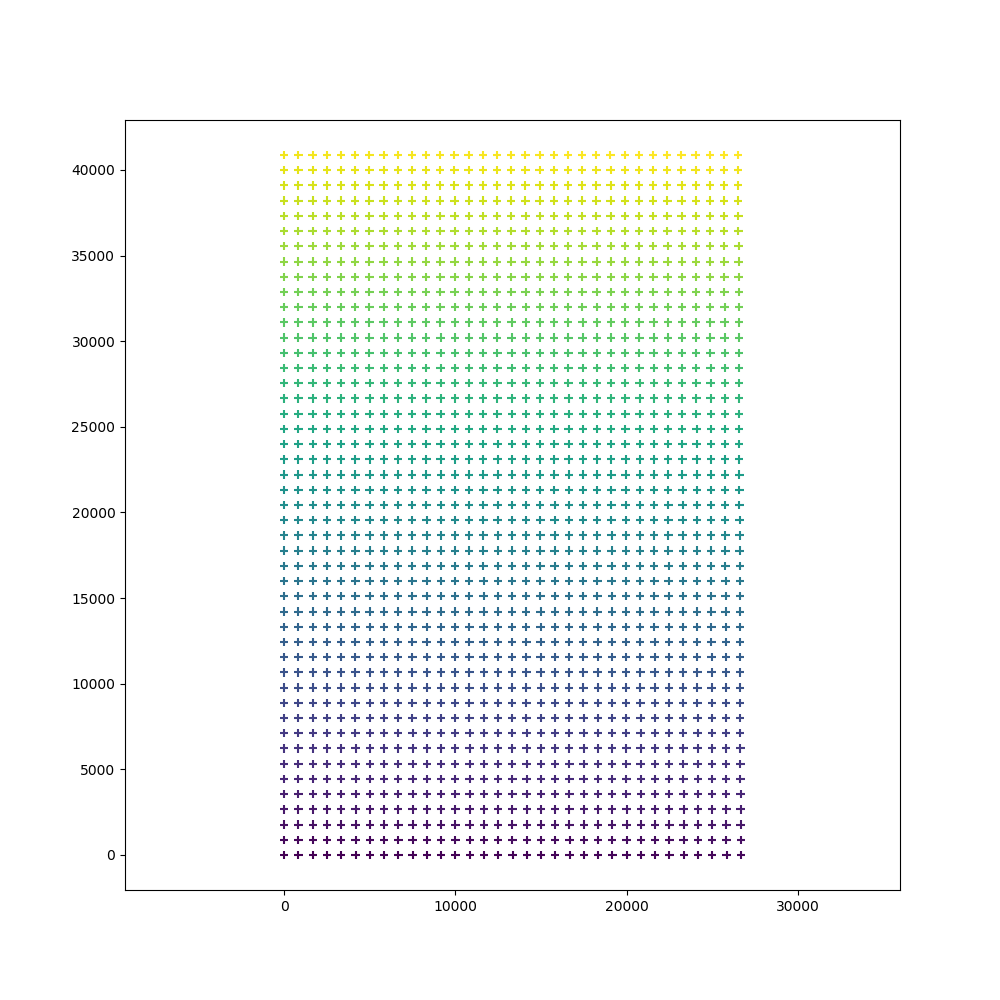

In [124]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.axis('equal')
plt.scatter(x,y,c=np.linspace(0,1,len(coords[:,1])),marker="+")
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [2]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, get_data_sub_paths
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from pprint import pprint
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage

In [3]:
from utils.utils import timeit

In [58]:
np.sort(get_data_sub_paths())

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')

In [ ]:
'T24H-X255M-Y220M_2013-01-01_2015-01-01',
'T24H-X425M-Y440M_2013-01-01_2015-01-01',
'T24H-X850M-Y880M_2013-01-01_2015-01-01',
'T24H-X850M-Y880M_2013-01-01_2017-01-01',
'T24H-X85M-Y110M_2013-01-01_2015-01-01',
'T12H-X850M-Y880M_2013-01-01_2015-01-01',
'T3H-X850M-Y880M_2013-01-01_2015-01-01',
'T6H-X850M-Y880M_2013-01-01_2015-01-01'
'T1H-X850M-Y880M_2013-01-01_2015-01-01',
'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',

In [49]:
class GRUFNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUFNN, self).__init__()

        self.name = "GRUFNN"

        self.gru = nn.GRU(input_size, hidden_size, num_layers)  # (seq_len, batch_size, n_features) format
        self.lin1 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x, h0=None):
        # Forward propagate RNN
        if h0 is not None:
            out, hn = self.gru(x, h0)
        else:
            out, hn = self.gru(x)
        out = self.relu(out)
        out = self.lin1(out)
        out = self.relu(out)

        return out  

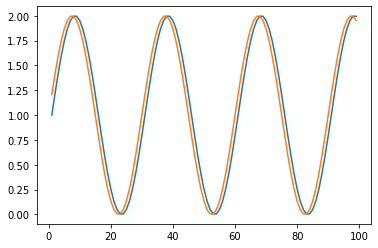

In [50]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
t = np.copy(y)
t = t[1:]
y = y[:-1]
x = x[1:]
plt.plot(x,y)
plt.plot(x,t)

y = np.expand_dims(y,-1)
y = np.expand_dims(y,-1)


t = np.expand_dims(t,-1)
t = np.expand_dims(t,-1)

In [51]:
inp = torch.Tensor(y)
trg = torch.Tensor(t)

criterion = nn.MSELoss()


model = GRUFNN(input_size=1, hidden_size=10, output_size=1)  # seq_len, batch_size, 
parameters = model.parameters()
optimiser = optim.Adam(params=parameters,
                       lr=1e-3,
                       weight_decay=0)
out = model(inp)


RuntimeError: Model needs to be fitted to the data first: model.fitted = False

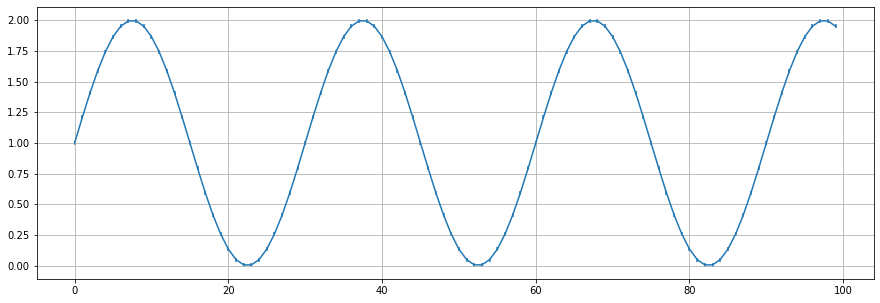

In [52]:
x = np.arange(100)
y = 1+ np.sin(2*np.pi*x/30) #+ np.sin(2*np.pi*x/100)
plt.figure(figsize=(15,5))
plt.plot(x,y)
plt.scatter(x,y,s=10,marker='|')
plt.grid()
for time_step in [1]:
    uno = UniformMovingAverage(window_len=3)
    ha = HistoricAverage(step=time_step)
    o = ha(y)
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="ha"+str(time_step))
    
    o = uno(y)
    
    plt.plot(x,o)
    plt.scatter(x,o,s=10,marker='|',label="un"+str(time_step))

plt.legend()
plt.show()

#### Ensure data_group for the grid and the . flat dataset are both working with the same data and same shaper and same dates

In [6]:
data_sub_paths = get_data_sub_paths()
np.sort(data_sub_paths)

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')

In [7]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))
data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')


In [8]:
conf = BaseConf()
conf.data_path = f"./data/processed/{data_sub_path}/"
conf.model_name = "dev-model"
conf.model_path = f"{conf.data_path}models/{conf.model_name}"

flat_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
flat_loaders = FlatDataLoaders(data_group=flat_group, conf=conf)

# grid_group = GridDataGroup(data_path=conf.data_path, conf=conf)
# grid_loaders = GridDataLoaders(data_group=grid_group, conf=conf)

finding best max_steps parameter...
mae:0.32433909843508624 max_steps:1
mae:0.31676744184550976 max_steps:2
mae:0.31442418926728627 max_steps:3
mae:0.31349086303722656 max_steps:4
mae:0.3130717137065485 max_steps:5
mae:0.3125419189551905 max_steps:6
mae:0.31221117439375334 max_steps:7
mae:0.312150949869142 max_steps:8
mae:0.3121889742660027 max_steps:9
mae:0.31228869990428815 max_steps:10
mae:0.31234742572805846 max_steps:11
mae:0.3123669961576262 max_steps:12
mae:0.31230923763478613 max_steps:13
mae:0.31220257166990867 max_steps:14
mae:0.31221788405456513 max_steps:15
mae:0.312272969451827 max_steps:16
mae:0.31238435356211425 max_steps:17
mae:0.31247845140458524 max_steps:18
mae:0.3125329181998676 max_steps:19
mae:0.31256066128168647 max_steps:20
mae:0.3125485102053217 max_steps:21
mae:0.3125682864735496 max_steps:22
mae:0.3126362531650864 max_steps:23
mae:0.3126957522859645 max_steps:24
mae:0.31279096228630554 max_steps:25
mae:0.31282046059278507 max_steps:26
mae:0.3128438726591473 m

In [9]:
flat_group.crimes.shape

(729, 3, 2300)

In [104]:
a = np.arange(101)
a[0] *= .4
a[0]

0

In [10]:
# time step in this context is used for 
freqstr = flat_group.t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
time_step

1

In [11]:
data = flat_group.crimes

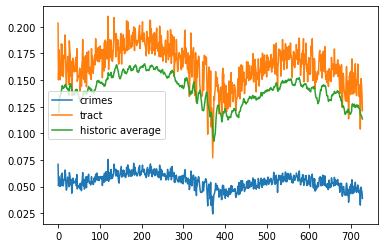

In [12]:
plt.plot(data[:,0].mean(-1),label="crimes")
plt.plot(data[:,1].mean(-1),label="tract")
plt.plot(data[:,2].mean(-1),label="historic average")
plt.legend()
plt.show()

In [16]:
from models.baseline_models import historic_average

In [107]:
def historic_average(data, step, max_steps):
    """
    historic_average get's the historic average of the following time step without including that time step.
    it get's the the historic average of each cell and then moves it one time step forward.
    We do not want to use the input cell's historic average because it's less related to the target cell

    :param data: (N, ...) shape
    :param step: interval used to calculate the average
    :param max_steps: number of intervals to sample
    :return: historic average of the next time steps
    """
    r = np.zeros(data.shape)  # so that calculation can still be done on the first few cells
    # r = np.empty(data.shape)
    # r.fill(np.nan)
    for i in range(step + 1, len(r)):
        a_subset = data[i - step + 1:0:-step]  # +1 to take the historic average of the next time step
        if max_steps > 0:
            a_subset = a_subset[:max_steps]

        x = np.mean(a_subset, axis=0)
        r[i] = x

    return r

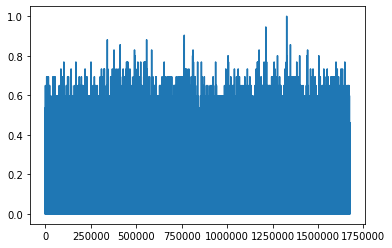

In [121]:
plt.plot(trgs.flatten())

In [133]:
def score_fn(y_true, y_score):
    y_true, y_score = y_true.flatten(), y_score.flatten()
    return np.mean(np.abs(y_true-y_score))  # mae
    y_true = np.copy(y_true)
    y_true[y_true > 0 ] = 1
    return np.mean(np.abs(y_true-y_score))  # mae
#     return average_precision_score(y_true,y_score)
    return roc_auc_score(y_true,y_score)

    

0.07431687001678344 0
0.07507306516136167 1
0.07331709160295118 2
0.07277231797712717 3
0.07255597767947396 4
0.0724591066612956 5
0.07233845365681581 6
0.07226153805411518 7
0.07224703033260722 8
0.07225609694711188 9
best -> 8
----------------------------------------------------
best param: 8


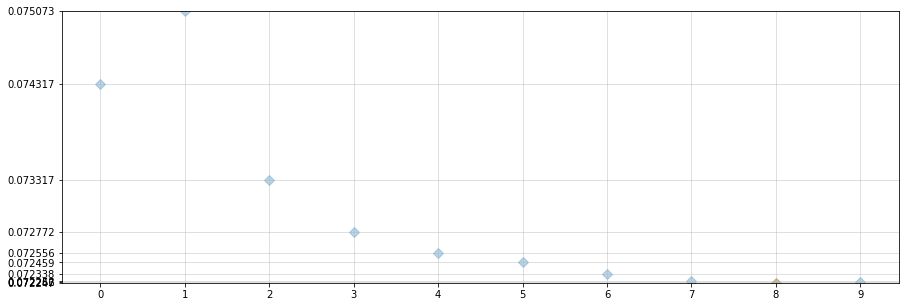

In [134]:
inpt = np.copy(flat_group.crimes[:,0])
trgs = np.copy(inpt)
trgs = trgs[1:]
inpt = inpt[:-1]

tst_len = int(0.3*len(inpt))

results = {}
for step in [1]:
    for max_steps in range(10):
        out = historic_average(inpt,step=step,max_steps=max_steps)
        
#         mae = np.mean(np.abs(trgs[tst_len:]-out[tst_len:]))
        mae = score_fn(trgs[tst_len:],out[tst_len:])
        
        results[mae] = max_steps
        print(mae,max_steps)
best = results[min(list(results.keys()))]        
print(f"best -> {best}")        
print("----------------------------------------------------")        
score, param = np.array(list(results.keys())), np.array(list(results.values()))
plt.figure(figsize=(15,5))
plt.scatter(param, score,s=50,marker="D",alpha=.3)
best_arg = np.argmin(score)
print("best param:",param[best_arg])
plt.scatter(param[best_arg], score[best_arg],s=50,marker="D",alpha=.3)
plt.ylim(np.min(score),np.max(score))
plt.xticks(param)
plt.yticks(score)
plt.grid(True,alpha=.5)

In [ ]:
im(grid_group.crimes.mean(0))

# mock data ensures the models work as they should

In [ ]:
# compare results and new thresh per cell vs original metric
metrics = get_models_metrics(conf.data_path)
results = get_models_results(conf.data_path)

In [ ]:
probas_pred = results[0].probas_pred
y_pred = results[0].y_pred
y_true = results[0].y_true

In [ ]:
thresholds = best_thresholds(y_true=y_true,
                             probas_pred=probas_pred)
best_t = best_threshold(y_true=y_true,
                             probas_pred=probas_pred)


In [ ]:
t = y_true.sum(0)[0]


In [ ]:
def norm(x):
    x -= x.min()
    x /= x.max()
    return x

In [ ]:
model_metrics = ModelMetrics(model_name=conf.model_name,
                             y_true=y_true,
                             y_pred=y_pred_new,
                             probas_pred=probas_pred)

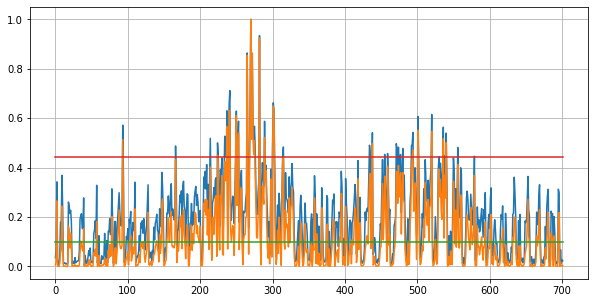

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(norm(thresholds))
# plt.plot(norm(t))
plt.plot(norm(norm(t)*norm(thresholds)))
plt.plot(np.ones(thresholds.shape)*best_t)
mean = np.mean(norm(t))
plt.plot(np.ones(thresholds.shape)*mean)
plt.grid()
plt.show()

In [ ]:

class0_args = np.zeros(10)
class1_args = np.ones(10)
a = np.arange(10)#np.array(list(zip(class0_args, class1_args))).flatten()
print(a)
np.random.shuffle(a)
print(a)

[0 1 2 3 4 5 6 7 8 9]
[3 0 6 7 9 2 4 8 1 5]


In [ ]:
# ensure all model weights are parameters

In [ ]:
# Kang FNN



In [ ]:
# ResNet


In [ ]:
# ResNet-Extra

In [ ]:
# Kang RNN

In [ ]:
grid_group.shaper.l, flat_group.shaper.l

(702, 702)

In [ ]:
def f(*xx):
    for y in xx:        
        x = y.testing_set.t_range
        print("tst: ",len(x), x[0]," -> ",x[-1],y.testing_set.target_shape)
    print()    
    for y in xx:          
        x = y.validation_set.t_range
        print("val: ",len(x), x[0]," -> ",x[-1],y.validation_set.target_shape)
    print()
    for y in xx:          
        x = y.training_set.t_range
        print("trn: ",len(x), x[0]," -> ",x[-1],'\t',y.training_set.target_shape)
    print()

f(grid_group, flat_group)

tst:  121 2014-09-03 00:00:00  ->  2015-01-01 00:00:00 [99, 47, 33]
tst:  466 2013-09-23 00:00:00  ->  2015-01-01 00:00:00 [99, 1, 702]

val:  54 2014-01-13 00:00:00  ->  2014-03-07 00:00:00 [33, 47, 33]
val:  399 2013-02-02 00:00:00  ->  2014-03-07 00:00:00 [33, 1, 702]

trn:  221 2014-02-15 00:00:00  ->  2014-09-23 00:00:00 	 [200, 47, 33]
trn:  566 2013-03-07 00:00:00  ->  2014-09-23 00:00:00 	 [200, 1, 702]



In [ ]:
grid_group.training_set.target_shape

[200, 47, 33]

In [ ]:
(365-30)*0.3

100.5

In [ ]:
data_path

'./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/'

------

In [ ]:
# plot the per time metrics for data folders
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"
# metrics = get_models_metrics(data_path)

In [ ]:
list(map(lambda x: plt.plot(), metrics))

['Historic Average',
 'Hawkes General Model',
 'Previous Time Step',
 'Ind-Hawkes Model',
 'Rolling Average',
 'Global Average']

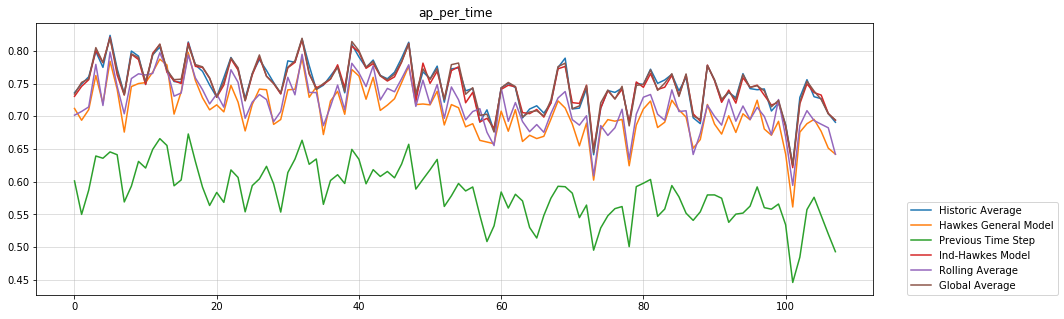

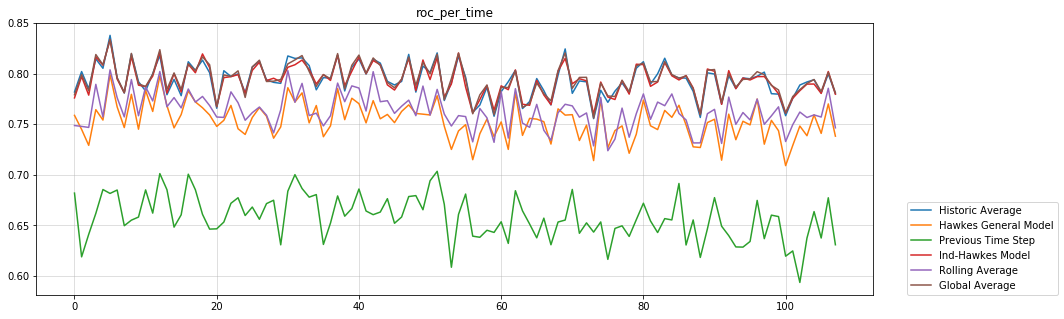

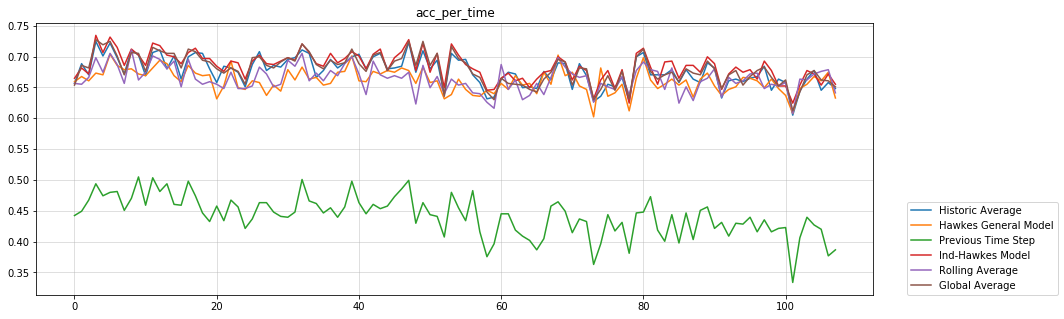

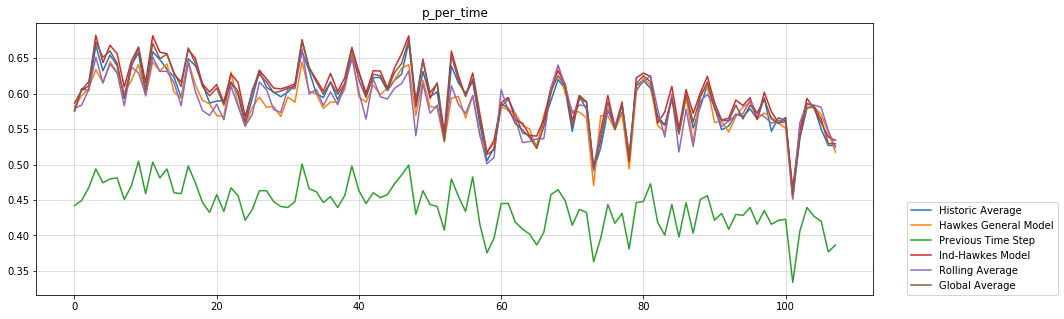

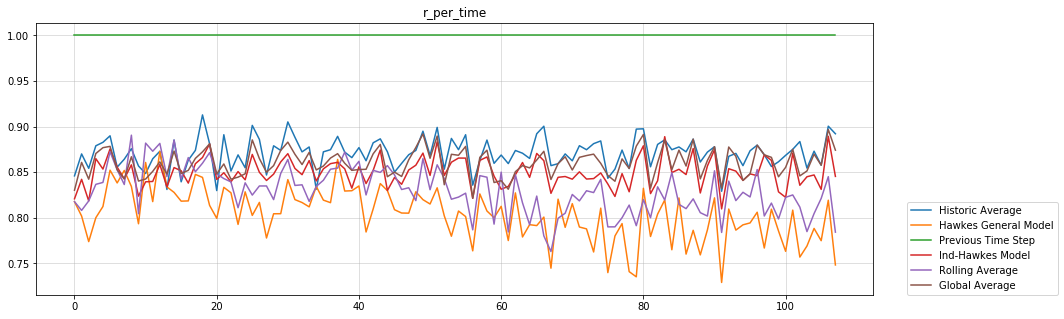

In [ ]:
data_group  

In [ ]:
conf = BaseConf()

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

NameError: name 'conf' is not defined

In [ ]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "NOTE-BOOK-MODEL"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": True,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": 1,
    "sub_sample_validation_set": 1,
    "sub_sample_validation_set": 0,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-11-03T11:35:19 | root | INFO | =====================================BEGIN=====================================
2019-11-03T11:35:19 | root | INFO | Device: cpu


In [ ]:
conf.sub_sample_test_set = False
conf.sub_sample_train_set = True
conf.sub_sample_validation_set = True

data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-03T11:35:21 | root | INFO | 	t_range shape (731,)


In [ ]:
pshape(data_group.crimes,
       data_group.training_set.crimes,
       data_group.testing_set.crimes,
       data_group.validation_set.crimes)

(729, 2, 9043)
(585, 2, 9043)
(474, 2, 9043)
(402, 2, 9043)


In [ ]:
N,L = 10, 10

np.arange(N*L).reshape(N,1,L)

array([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]],

       [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

       [[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]],

       [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]],

       [[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]],

       [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59]],

       [[60, 61, 62, 63, 64, 65, 66, 67, 68, 69]],

       [[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]],

       [[80, 81, 82, 83, 84, 85, 86, 87, 88, 89]],

       [[90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]])